### This code 
- Estimates HSSW production rates in TNB from AWA Manuela and ERA 5 variables across 2012-2021
- Generates Figure 5 of the manuscript



In [1]:
import os
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import pandas as pd
import scipy.io as sio

import gsw
import numpy.ma as ma
from matplotlib import ticker
from matplotlib.dates import DateFormatter
%matplotlib inline
import datetime

# 1. Load in the following:

`p_area_decade.csv` This is average polynya area calculated over June-October of 2012-2021 from the Universtiy of Bremen $3.125 km^{2}$ resolution SIC product <br>
`era_aws_merge.csv` This is AWS Manuela data and ERA5 variables aligned on 6 hour intervals across the years 2012-2012 <br>
>'u10', 'v10', 'd2m', 't2m', 'lsm', 'msl', 'siconc', 'sst', 'skt', 'tcc' are ERA5 variables <br>
>'Airtemp', 'Pressure','Wndspd', 'Wnddir', 'Humidity', 'DelT', 'Date', 'ds_match' are AWS Manuela Variables

In [2]:
p_area_decade = pd.read_csv('p_area_decade.csv') # Satellite-derived polynya areas
p_area_decade = p_area_decade.set_index('Year')
p_area_decade

,p_area
Year,
2012,491.403
2013,811.817
2014,545.446
2015,384.381
2016,618.728
2017,578.287
2018,674.238
2019,961.954
2020,849.451


In [3]:
era_aws_merge = pd.read_csv('era_aws_merge.csv').set_index('Unnamed: 0') 
era_aws_merge.index = pd.to_datetime(era_aws_merge.index) # Convert index to datetime
era_aws_merge

,u10,v10,d2m,t2m,lsm,msl,siconc,sst,skt,tcc,...,Day,Time,Airtemp,Pressure,Wndspd,Wnddir,Humidity,DelT,Date,ds_match
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2012-02-07 06:00:00,5.343457,0.408588,259.42725,268.40588,0.08944,99917.290,0.023872,271.50990,270.54712,0.000000,...,7.0,600.0,-4.8,988.5,7.5,298.0,444.0,444.0,2012 2 7,True
2012-02-07 12:00:00,5.348006,-0.726706,260.20800,268.17227,0.08944,99824.400,0.023872,271.50990,270.21362,0.000000,...,7.0,1200.0,-7.6,987.5,8.8,318.0,48.0,444.0,2012 2 7,True
2012-02-07 18:00:00,6.459033,-0.765265,260.68158,267.58554,0.08944,99663.590,0.023872,271.50990,270.29724,0.003899,...,7.0,1800.0,-8.5,984.9,17.7,299.0,44.3,444.0,2012 2 7,True
2012-02-08 00:00:00,7.439118,-0.751288,259.41595,268.29290,0.08944,99511.540,0.024837,271.55440,270.73685,0.000000,...,8.0,0.0,-6.0,983.6,16.1,296.0,39.6,444.0,2012 2 8,True
2012-02-08 06:00:00,8.449914,0.072832,259.46622,269.05215,0.08944,99447.120,0.024837,271.55440,270.66190,0.000000,...,8.0,600.0,-4.2,981.3,20.6,291.0,40.0,444.0,2012 2 8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30 00:00:00,-0.158234,4.986159,267.37480,270.73166,0.08944,98394.020,0.258629,272.82562,272.78348,0.993473,...,30.0,0.0,-5.1,974.5,6.0,203.0,87.0,444.0,2021 12 30,True
2021-12-30 06:00:00,0.447925,2.959714,267.16068,270.94962,0.08944,98654.260,0.258629,272.82562,272.70465,0.999322,...,30.0,600.0,-3.8,976.6,4.9,197.0,91.0,444.0,2021 12 30,True
2021-12-30 12:00:00,1.469363,-0.097232,266.69498,270.80430,0.08944,98862.100,0.258629,272.82562,271.77612,0.987386,...,30.0,1200.0,-3.8,978.7,1.3,299.0,95.9,444.0,2021 12 30,True


# 2. Calculate net heat flux and corresponding HSSW production rate for each year in 2012-2022

In [10]:
df = pd.DataFrame(data = {'Q_net11': [np.nan],'Q_net22': [np.nan],'Q_s': [np.nan], 'Q_b': np.nan, 'Q_H':np.nan, #Initial empty dataframe for loop
                          'Q_E':np.nan, 'p_hssw_11': [np.nan], 'p_hssw_22': [np.nan]}, index= ['2011'])



for i in np.arange(2012,2022): #2022
    
    era_aws_merge_single = era_aws_merge[pd.to_datetime(str(i) + ' 7 1'):pd.to_datetime(str(i) + ' 11 01')] # Calculate over July - October
     
    ################# Solar radiation (Q_S)
    
    # C_c, cloud cover correction
    alpha1 = 1
    alpha2 = 0.6
    alpha3 = 3
    alpha4 = 0

    S_a = np.expand_dims(1.353 * 1000,axis=0) #watts per square metre
    C_c = np.expand_dims(alpha1 - alpha2*era_aws_merge_single.tcc**alpha3, axis = 0) #cloud cover is dimensionaless
    
    latitude = -75
    longitude = 165
    declination = 23.44 * np.cos((172 - pd.to_datetime(era_aws_merge_single.index.values).day_of_year) * 2*np.pi/365)

    LSTM = 15 * 13 #https://www.pveducation.org/pvcdrom/properties-of-sunlight/solar-time
    B = 360/365 * ((pd.to_datetime(era_aws_merge_single.index.values) + pd.Timedelta(hours=13)).day_of_year - 81)
    EoT = 9.87 * np.sin(np.radians(2*B)) - 7.53*np.cos(np.radians(B)-1.5*np.sin(np.radians(B)))
    TC = 4 * (longitude - LSTM) + EoT
    LST = (pd.to_datetime(era_aws_merge_single.index.values) + pd.Timedelta(hours=13)).hour + TC/60 #local solar time 
    HA = 15 * (LST-12)
    
    cosZ = np.sin(np.radians(latitude))*np.sin(np.radians(declination.values)) + np.cos(np.radians(latitude))*np.cos(np.radians(declination.values))*np.cos(np.radians(HA.values))
    cosZ = ma.masked_less(cosZ,0)

    eT = 611 * 10**(7.5*(era_aws_merge_single.d2m-273.16)/(era_aws_merge_single.d2m-35.86)) # simonsen adn haugen. Units of Pa https://www.myroms.org/wiki/Radiant_Heat_Fluxes
    eTs = 611 * 10**(7.5*(era_aws_merge_single.sst-273.16)/(era_aws_merge_single.sst-35.86))  #parkinson washington
    
    T_r = cosZ/(cosZ+((1 + cosZ)*eT.values*10**-5)+0.046)
    

    Q_s_single = ((1-0.08)*C_c*T_r*S_a*cosZ).filled(0).mean() #Simonson & haugan use alpha =0.06 for open water, so 0.08 seems right
    
    ################## Net longwave radiation (Q_b)
    
    epsilon = 0.95 # ocean emissivity https://www.tandfonline.com/doi/pdf/10.1080/07055900.1991.9649392
    sigma = 5.670367 * 10**-8 # W m−2 K−4
    e_m = 0.7829*(1 + 0.2232*era_aws_merge_single.tcc**2.75)

    Q_b = 4 * epsilon * sigma * era_aws_merge_single.t2m**3*(era_aws_merge_single.t2m - era_aws_merge_single.sst) + epsilon * sigma * era_aws_merge_single.t2m**4*(0.39-0.05*(eT)**.5)*(1-0.82*era_aws_merge_single.tcc**2)
    
    Q_b_single = Q_b.mean()
    #Turbulent heat fluxes
    
    mixing_ratio = 621.97*(eT/100)/(era_aws_merge_single.msl/100-(eT/100)) #https://www.weather.gov/media/epz/wxcalc/mixingRatio.pdf
    virtual_temp = era_aws_merge_single.t2m + mixing_ratio/6 
    rho_a = era_aws_merge_single.msl/(287.05 * virtual_temp) #density of MOIST air https://www.usna.edu/Users/oceano/barrett/SO414/Lesson2.pdf

    V = era_aws_merge_single.Wndspd/1.5 #Divide AWS wind speed by factor to correct for attenuation between AWS Site and the polynya
    c_p = 1004 #J kg K

    
    ################# Turbulent heat fluxes: Sensible (Q_H) and Latent (Q_E)


    Q_H_11 = (rho_a * c_p * 1.1e-3 * V * (era_aws_merge_single.t2m - era_aws_merge_single.sst)).mean()
    Q_H_22 = (rho_a * c_p * 2.2e-3 * V * (era_aws_merge_single.t2m - era_aws_merge_single.sst)).mean()
    

    L_E = 2.5e6 # Parkinson and WAshington, simonson
    C_E = 1.1e-3
    q_10m = 0.622*eT/(era_aws_merge_single.msl-0.378*eT)
    q_s = 0.622*eTs/(era_aws_merge_single.msl-0.378*eTs)

    
    Q_E_11 = (rho_a * L_E * 1.1e-3 * V * (q_10m - q_s)).mean() # Use 1.1 X 10^-3 heat transfer coefficient
    Q_E_22 = (rho_a * L_E * 2.2e-3 * V * (q_10m - q_s)).mean() # Use 1.3 X 10^-3 heat transfer coefficient

    ################# Calculate net heat fluxes
    
    Q_net_11 = Q_s_single + Q_b_single + Q_E_11 + Q_H_11 
    Q_net_22 = Q_s_single + Q_b_single + Q_E_22 + Q_H_22 
    
    ################# Calculation of HSSW production rate (Equations 11, 12, and 4 in the manuscript)
    P_i_11 = -Q_net_11/(0.95e3*3.34e5)
    P_i_22 = -Q_net_22/(0.95e3*3.34e5)
    
    s_hssw = 34.81 #salinity of HSSW
    s_lssw = 34.79 #salinity of LSSW
    
    P_s_11 = 0.95e3 * P_i_11 * p_area_decade.loc[i].p_area * 1000**2 * (1-0.31)*s_lssw * 10**-3 # sat release in polynya per day (kg/s) #34.5 from van woert book
    P_s_22 = 0.95e3 * P_i_22 * p_area_decade.loc[i].p_area * 1000**2 * (1-0.31)*s_lssw * 10**-3 # sat release in polynya per day (kg/s) #34.5 from van woert book


    P_hssw_11 = P_s_11/(1028 * (s_hssw -s_lssw) * 10**-3) * 10**-6#m^3/s
    P_hssw_22 = P_s_22/(1028 * (s_hssw -s_lssw) * 10**-3) * 10**-6#m^3/s  

    df = df.append(pd.DataFrame(data = {'Q_net11':Q_net_11.mean(), 'Q_net22':Q_net_22.mean(),
                                        'Q_s': Q_s_single, 'Q_b': Q_b_single, 'Q_H':Q_H_11, 'Q_E':Q_E_11,
                                        'p_hssw_11': P_hssw_11, 'p_hssw_22': P_hssw_22}, index = [i]))


df = df.dropna()
df

# Q_net11: Net heat flux (negative out of TNB) calculated using the 1.1 X 10^-3 heat transfer coefficient
# Q_s: Shortwave radiation calculated using the 1.1 X 10^-3 heat transfer coefficient
# Q_b: Longwave radiation calculated using the 1.1 X 10^-3 heat transfer coefficient
# Q_H: Sensible heat flux calculated using the 1.1 X 10^-3 heat transfer coefficient
# Q_E: Latent heat flux calculated using the 1.1 X 10^-3 heat transfer coefficient
# p_hssw_11: HSSW production rate calculated from Q_net using 1.1 X 10^-3 heat transfer coefficient
# p_hssw_13: HSSW production rate calculated from Q_net using 1.3 X 10^-3 heat transfer coefficient

,Q_net11,Q_net22,Q_s,Q_b,Q_H,Q_E,p_hssw_11,p_hssw_22
2012,-466.721720,-911.693620,48.994742,-70.744563,-323.999140,-120.972759,0.801733,1.566104
2013,-423.726664,-827.343657,52.654720,-72.764390,-291.502312,-112.114682,1.202480,2.347892
2014,-473.896077,-925.417636,48.520682,-70.895200,-323.721375,-127.800183,0.903585,1.764507
2015,-496.695558,-965.543258,43.441917,-71.289775,-343.399076,-125.448625,0.667400,1.297381
2016,-476.444821,-936.246706,55.863610,-72.506545,-332.043154,-127.758731,1.030496,2.024995
2017,-557.389829,-1093.306662,52.464848,-73.937843,-390.623143,-145.293691,1.126773,2.210138
2018,-469.188911,-912.014831,45.653084,-72.016076,-318.347058,-124.478862,1.105847,2.149558
2019,-458.000853,-893.368378,47.327564,-69.960892,-309.180444,-126.187081,1.540120,3.004131
2020,-457.106321,-893.063995,50.522986,-71.671634,-311.939834,-124.017839,1.357343,2.651886
2021,-445.533258,-873.036753,54.144955,-72.174718,-304.280677,-123.222818,1.606802,3.148581


# 3. Plot Figure 5

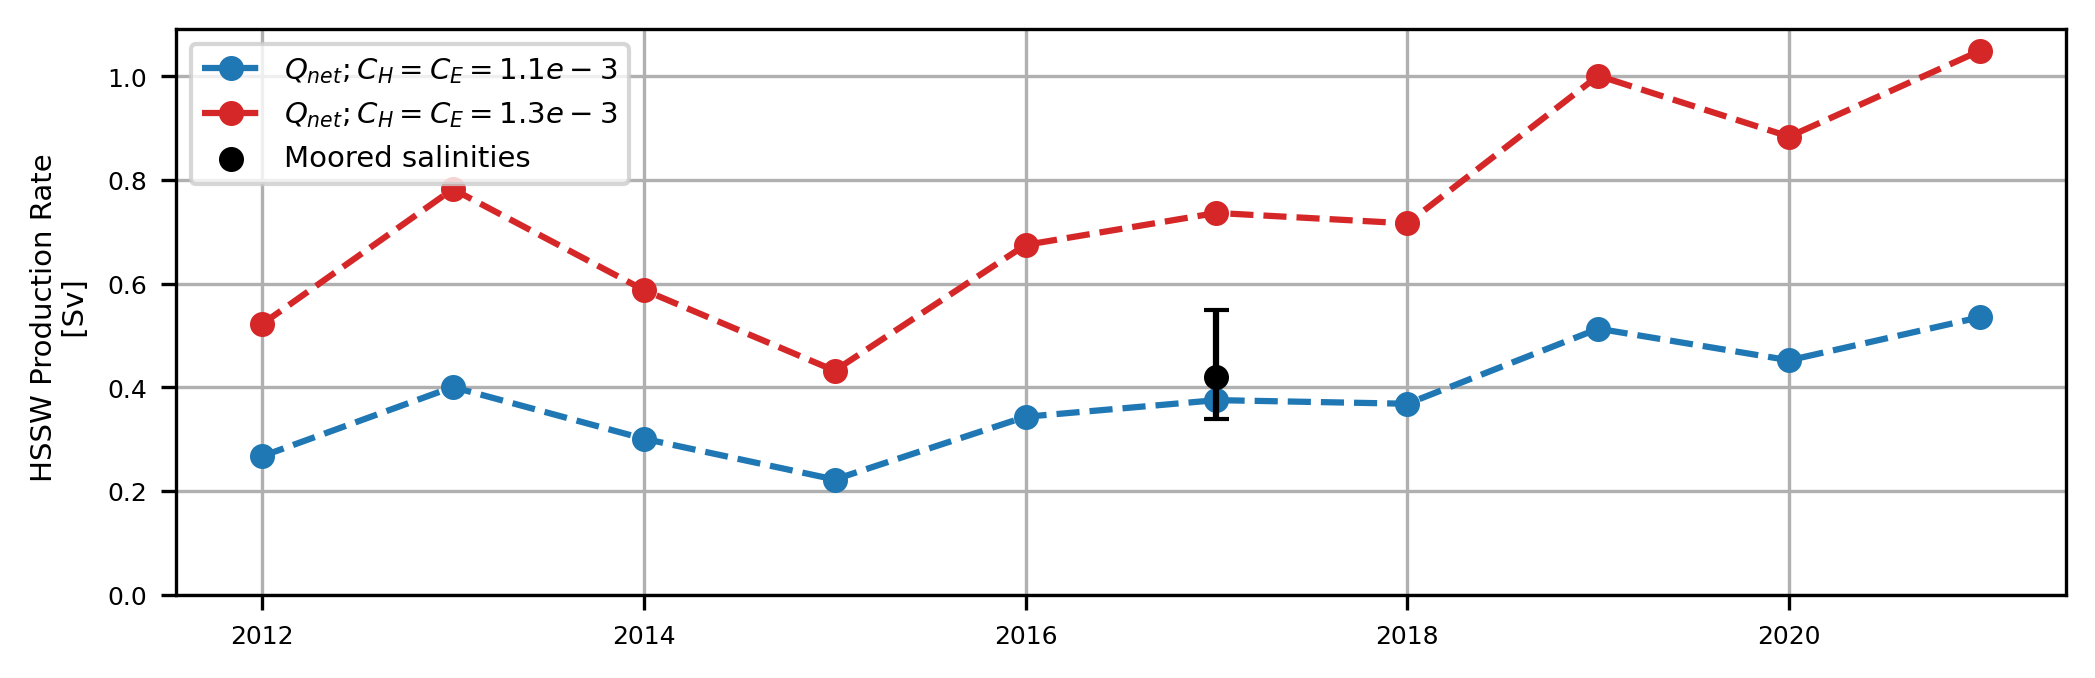

In [17]:
cm = 1/2.54 
fig,ax=plt.subplots(figsize=(18*cm,6*cm),dpi=300) 



plt.xlabel('')
plt.ylabel('HSSW Production Rate \n [Sv]',fontsize=7)
plt.grid()
plt.scatter(2017,0.42,  label='Moored salinities',zorder=10, c = 'k', s = 25) #color='#004488',
plt.errorbar(2017, 0.445 , yerr=0.105, fmt='none', capsize=3, color = 'k', zorder = 15)

(df.p_hssw_11*4/12).plot(marker ='.', label='$Q_{net}; C_{H}=C_{E}=1.1e-3$', markersize = 10,linestyle='--', color = 'tab:blue')

(df.p_hssw_22*4/12).plot(marker ='.', label='$Q_{net}; C_{H}=C_{E}=1.3e-3$',markersize = 10, linestyle='--', color = 'tab:red')

plt.yticks(np.arange(0,1.2,0.2))

plt.legend(fontsize=7, loc=2)
ax.tick_params(labelsize=6)
plt.tight_layout()
plt.grid()